# Authorship Analysis

This Jupyter notebook uses statistical methods to analyze the authorship of a text. The text is split into words, and the frequency of each word is calculated. The frequency of each word is then compared to the frequency of the same word in a training set of texts of known authorship. The authorship of the text is then predicted based on the similarity of the word frequencies.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
from multiprocess import Pool

import os
import sys
from typing import List, Tuple, Dict, Callable, Union, Any, Optional, Self, Set

# Tokenization

The first step in the analysis is to tokenize the text. Tokenization is the process of splitting the text into words. The text is split into words using the `nltk` library.

# Frequency Analysis

The next step is to calculate the frequency of each word in the text. The frequency of each word is calculated by counting the number of times the word appears in the text and dividing by the total number of words in the text.

In [23]:
def tokenize(text: str) -> List[str]:
    '''
    Takes a string and returns a list of words.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
    
    Returns
    -------
    List[str]
        A list of words.
    '''
    # Split on whitespace and punctuation
    text = text.lower()
    
    # Split on punctuation
    for p in '!"#$%()*+,-./:;<=>?@[\\]^_`{|}~':
        text = text.replace(p, ' ' + p + ' ')
    
    return text.split()

def tokens_to_sentences(tokens: List[str]) -> List[str]:
    '''
    Takes a list of tokens and returns a list of sentences.
    
    Parameters
    ----------
    tokens : List[str]
        The tokens to be converted to sentences.
        
    Returns
    -------
    List[str]
        A list of sentences.
    '''
    sentences = []
    sentence = []
    for token in tokens:
        sentence.append(token)
        if token in '.!?':
            sentences.append(' '.join(sentence))
            sentence = []
    return sentences

def word_count(text: str) -> int:
    '''
    Takes a string and returns the number of words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of words in the text.
    '''
    return len(tokenize(text))

def avg_word_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the words in the text.
    '''
    words = tokenize(text)
    return sum(len(word) for word in words) / len(words)

def unique_words(text: str) -> int:
    '''
    Takes a string and returns the number of unique words in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    int
        The number of unique words in the text.
    '''
    return len(set(tokenize(text)))

def avg_sentence_length(text: str) -> float:
    '''
    Takes a string and returns the average length of the sentences in it.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    float
        The average length of the sentences in the text.
    '''
    sentences = tokens_to_sentences(tokenize(text))
    return sum(len(sentence) for sentence in sentences) / len(sentences)

def word_count_map(text: str) -> Dict[str, int]:
    '''
    Takes a string and returns a dictionary of words and their counts.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, int]
        A dictionary of words and their counts.
    '''
    return {word: text.count(word) for word in tokenize(text)}

def word_freq(text: str) -> Dict[str, float]:
    '''
    Takes a string and returns a dictionary of words and their frequencies.
    
    Parameters
    ----------
    text : str
        The text to be tokenized.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of words and their frequencies.
    '''
    # wc = word_count(text)
    # return {word: count / wc for word, count in word_count_map(text).items()}
    
    # Do it in parallel with multiprocessing
    # Split up the text into chunks for each process
    # Send each chunk to a different process
    # Combine the results
    
    def partition_text(text: str, partitions: int=16) -> list[str]:
        length = len(text)
        chunk_size = length // partitions
        return [text[i:i+chunk_size] for i in range(0, length, chunk_size)]
        
    text_partitions = partition_text(text)
    with Pool(16) as pool:
        results = pool.map(word_count_map, text_partitions)
    
    # Combine the results
    combined = {}
    for result in results:
        for word, count in result.items():
            combined[word] = combined.get(word, 0) + count
    
    wc = sum(combined.values())
    return {word: count / wc for word, count in combined.items()}

# Corpus

This implements an abstraction for managing a corpus of texts. The corpus is a collection of texts, each of which has an author and a title. The corpus can be used to train a model to predict the authorship of a text.

In [24]:
class Corpus:
    '''
    A class to represent a corpus of text data.
    
    This provides abstractions for managing text data, including:
    - reading data from files
    - managing multiple works with separate metadata
    '''
    
    def __init__(self, name: str):
        '''
        Initialize a new Corpus object.
        
        Parameters
        ----------
        name : str
            The name of the corpus. This is used to identify the corpus, maybe used in plots, etc.
            Should be a short, descriptive name, that distinguishes this corpus from others.
        '''
        self.works = []
        self.name = name
        
    def chunk_sentences(self, chunk_size: int) -> Self:
        '''
        Create a new corpus by chunking sentences in the current corpus.
        This will create several works from each work in the current corpus.
        Each work will contain a chunk of sentences from the original work.
        
        Parameters
        ----------
        chunk_size : int
            The number of sentences to include in each chunk.
            
        Returns
        -------
        Corpus
            A new corpus with the chunked sentences.
        '''
        
        new_works = []
        for work in self.works:
            sentences = tokens_to_sentences(tokenize(work['text']))
            if len(sentences) < chunk_size:
                continue
            
            for i in range(0, len(sentences), chunk_size):
                chunk = ' '.join(sentences[i:i+chunk_size])
                if len(tokenize(chunk)) < 10:
                    continue
                new_works.append({**work, 'text': chunk})
        
        new_corpus = Corpus(f'{self.name} (chunked)')
        new_corpus.works = new_works
        return new_corpus
    
    def add_paths(self, paths: List[str], author: str, **metadata):
        '''
        Add multiple works to the corpus from files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        for path in paths:
            with open(path, 'r') as f:
                text = f.read()
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            self.add_work(title, author, text, **metadata)    
    
    def add_work(self, title: str, author: str, text: str, **metadata):
        '''
        Add a new work to the corpus.
        
        Parameters
        ----------
        title : str
            The title of the work.
        author : str
            The author of the work.
        text : str
            The text of the work.
        metadata : dict
            Additional metadata about the work, such as publication date, genre, etc.
        '''
        self.works.append({'title': title, 'author': author, 'text': text, **metadata})
    
    def from_paths(name: str, paths: List[str], author: str, **metadata) -> Self:
        '''
        Load multiple works from files.
        
        Parameters
        ----------
        paths : List[str]
            A list of file paths to read texts from.
        author : str
            The author of the works.
        metadata : dict
            Additional metadata about the works.
        '''
        works = Corpus(name)
        for path in paths:
            with open(path, 'r') as f:
                text = f.read()
            title = os.path.basename(path).replace('.txt', '').replace('_', ' ').title()
            works.add_work(title, author, text, **metadata)
        return works
    
    def collate_texts(self) -> str:
        '''
        Combine all texts in the corpus into a single string.
        
        Returns
        -------
        str
            A single string containing all the text in the corpus.
        '''
        return '\n\n'.join(work['text'] for work in self.works)
    
    def get_authors(self) -> List[str]:
        '''
        Get a list of authors in the corpus.
        
        Returns
        -------
        List[str]
            A list of the authors in the corpus.
        '''
        return list(set([work['author'] for work in self.works]))
    
    def get_titles(self) -> List[str]:
        '''
        Get a list of titles in the corpus.
        
        Returns
        -------
        List[str]
            A list of the titles in the corpus.
        '''
        return [work['title'] for work in self.works]
    
    def get_texts(self) -> List[str]:
        '''
        Get a list of texts in the corpus.
        
        Returns
        -------
        List[str]
            A list of the texts in the corpus.
        '''
        return [work['text'] for work in self.works]
    
    def get_works_by_author(self, author: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific author.
        
        Parameters
        ----------
        author : str
            The author to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works by the specified author.
        '''
        return [work for work in self.works if work['author'] == author]
    
    def get_works_by_title(self, title: str) -> List[Dict[str, str]]:
        '''
        Get a list of works by a specific title.
        
        Parameters
        ----------
        title : str
            The title to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works with the specified title.
        '''
        return [work for work in self.works if work['title'] == title]
    
    def get_works_by_metadata(self, **metadata) -> List[Dict[str, str]]:
        '''
        Get a list of works that match specific metadata criteria.
        
        Parameters
        ----------
        metadata : dict
            The metadata criteria to filter works by.
        
        Returns
        -------
        List[Dict[str, str]]
            A list of works that match the specified metadata criteria.
        '''
        return [work for work in self.works if all(work[key] == value for key, value in metadata.items())]
    
    def get_word_counts_per_work(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their counts.
        '''
        return {work['title']: word_count_map(work['text']) for work in self.works}
    
    def get_word_counts_per_author(self) -> Dict[str, Dict[str, int]]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, int]]
            A dictionary of word counts for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their counts.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_count_map(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_counts(self) -> Dict[str, int]:
        '''
        Get a dictionary of word counts for the entire corpus.
        
        Returns
        -------
        Dict[str, int]
            A dictionary of words and their counts in the entire corpus.
        '''
        return word_count_map(self.collate_texts())
    
    def get_word_freq_per_work(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the titles of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        return {work['title']: word_freq(work['text']) for work in self.works}
    
    def get_word_freq_per_author(self) -> Dict[str, Dict[str, float]]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, Dict[str, float]]
            A dictionary of word frequencies for each work in the corpus.
            The keys are the authors of the works, and the values are dictionaries
            of words and their frequencies.
        '''
        result = {}
        for author in self.get_authors():
            print(f'Starting {author}')
            result[author] = word_freq(' '.join(work['text'] for work in self.get_works_by_author(author)))
            print(f'Finished {author}')
        return result
    
    def get_word_freq(self) -> Dict[str, float]:
        '''
        Get a dictionary of word frequencies for the entire corpus.
        
        Returns
        -------
        Dict[str, float]
            A dictionary of words and their frequencies in the entire corpus.
        '''
        return word_freq(self.collate_texts())
    
    def __repr__(self):
        return f'Corpus({self.name!r})'
    
    def __str__(self):
        return f'Corpus: {self.name} ({len(self.works)} works)'
    
    def __len__(self):
        return len(self.works)
    
    def __getitem__(self, idx: int) -> Dict[str, str]:
        return self.works[idx]
    
    def __iter__(self):
        return iter(self.works)
    
    def __contains__(self, title: str) -> bool:
        return any(title == work['title'] for work in self.works)
    
    def __add__(self, other: Self) -> Self:
        new = Corpus(f'{self.name} + {other.name}')
        new.works = self.works + other.works
        return new
    
    def __iadd__(self, other: Self) -> Self:
        self.works.extend(other.works)
        return self
    
    def __eq__(self, other: Self) -> bool:
        return self.name == other.name and self.works == other.works
    
    def __ne__(self, other: Self) -> bool:
        return not (self == other)
    
    def __bool__(self) -> bool:
        return bool(self.works)
    
    def __dir__(self) -> List[str]:
        return list(self.__dict__.keys()) + [work for work in self.works[0]]

In [25]:
ac_paths = os.listdir('data/ac')
ac_paths = [os.path.join('data/ac', path) for path in ac_paths]

ml_paths = os.listdir('data/ml')
ml_paths = [os.path.join('data/ml', path) for path in ml_paths]

gc_paths = os.listdir('data/gc')
gc_paths = [os.path.join('data/gc', path) for path in gc_paths]

lc_paths = os.listdir('data/lc')
lc_paths = [os.path.join('data/lc', path) for path in lc_paths]

hm_paths = os.listdir('data/hm')
hm_paths = [os.path.join('data/hm', path) for path in hm_paths]

corpus = Corpus.from_paths('Agatha Christie Dataset', ac_paths, 'Agatha Christie', genre='mystery')
corpus.add_paths(ml_paths, 'Maurice Leblanc', genre='mystery')
corpus.add_paths(gc_paths, 'GK Chesterton', genre='mystery')
corpus.add_paths(lc_paths, 'Lewis Carroll', genre='fantasy')
corpus.add_paths(hm_paths, 'Herman Melville', genre='adventure')

validation_paths = os.listdir('data/provided-validation-dataset')
validation_paths = [os.path.join('data/provided-validation-dataset', path) for path in validation_paths]
validation_corpus = Corpus.from_paths('Agatha Christie Validation Dataset', validation_paths, 'Agatha Christie', genre='mystery')

print(corpus)

Corpus: Agatha Christie Dataset (64 works)


In [26]:
def get_most_used_words(corpus: Corpus, count: int = 500) -> Dict[str, float]:
    '''
    Look at all the works in the corpus, and return a dictionary of the most used words
    to their frequency in the corpus.
    
    Parameters
    ----------
    corpus : Corpus
        The corpus of works to analyze.
        
    Returns
    -------
    Dict[str, float]
        A dictionary of the most used words in the corpus to their frequency (0-1, over the entire corpus).
    '''
    # Get the word frequencies for the entire corpus
    word_freq = corpus.get_word_freq()
    
    # Get the top most common words
    return {word: freq for word, freq in sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:count]}

# Get the top most common words in each work
# top_word_freq = {work: {word: freq for word, freq in sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:20]} for work, freqs in word_freq.items()}
# print(top_word_freq)

# top_words = get_most_used_words(corpus)
# print(top_words)
# word_freq_per_work = corpus.get_word_freq_per_work()
# # Get the word counts for each work in the corpus
# print(word_freq_per_work)

In [27]:
# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
# top_words_list = list(top_words.keys())
# top_word_freq = {work['title']: {word: freq for word, freq in word_freq_per_work[work['title']].items() if word in top_words_list} for work in corpus}

# Use a different color for each author
# df = pd.DataFrame(top_word_freq).fillna(0)
# Get a list of authors
authors = corpus.get_authors()
# Create a color palette
palette = sns.color_palette('hsv', len(authors))
# Create a dictionary mapping authors to colors
colors = {author: palette[i] for i, author in enumerate(authors)}
# Create a list of colors for each work
work_colors = [colors[author] for author in corpus.get_authors()]
# Plot the heatmap with the colors
# sns.heatmap(df, cmap='Blues', cbar=False)
# plt.title('Word Counts per Work')
# plt.show()

In [28]:
# Get the frequencies of the top words in each work
# For each of the words in the top words, get the frequency in each work
# top_words_list = list(top_words.keys())
# word_freq_per_author = corpus.get_word_freq_per_author()
# top_word_freq = {work['author']: {word: freq for word, freq in word_freq_per_author[work['author']].items() if word in top_words_list} for work in corpus}

In [29]:
# Use a different color for each author
# df = pd.DataFrame(top_word_freq).fillna(0)

# sns.heatmap(df, cmap='Blues', cbar=False)
# plt.title('Word Frequencies per Author')
# plt.show()

In [30]:
# Cluster all the works by their frequencies of all the top words
# Use k-means clustering to group the works by their word frequencies

# Alternative clustering methods:
# - Hierarchical clustering
# - DBSCAN
# - Spectral clustering
# - Affinity propagation

# Use hierarchical clustering to group the works by their word frequencies
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# avg_sentences_per_work = {work['title']: avg_sentence_length(work['text']) for work in corpus}
# avg_word_lengths_per_work = {work['title']: avg_word_length(work['text']) for work in corpus}

# def tokens_to_numbers(tokens: List[str], bank: Set[str] | None = None) -> List[int]:
#     # For every token, replace it with its index in the bank
#     if bank is None:
#         bank = set(tokens)
#     bank = {token: i for i, token in enumerate(bank)}
#     return [bank[token] for token in tokens if token in bank]

# all_tokens = tokenize(corpus.collate_texts())

# def get_words_in_percentile_range(work: Dict[str, Any], lower: float, upper: float) -> List[str]:
#     word_freqs = word_freq_per_work[work['title']]
#     # Sort them by frequency
#     sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)
#     # Get the words in the percentile range
#     # Do this by slicing the sorted list
#     lower_idx = int(len(sorted_words) * lower)
#     upper_idx = int(len(sorted_words) * upper)
#     return [word for word, freq in sorted_words[lower_idx:upper_idx]]

def vocab_richness(work: Dict[str, Any]) -> float:
    # Get the number of unique words
    unique = unique_words(work['text'])
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of unique words to total words
    return unique / total

def punctuation_density(work: Dict[str, Any]) -> float:
    # Get the number of punctuation marks
    punctuation = sum(1 for char in work['text'] if char in '.,?!')
    # Get the total number of characters
    total = len(work['text'])
    
    # Return the ratio of punctuation marks to total characters
    return punctuation / total

def sentence_length_variation(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the lengths of the sentences
    lengths = [len(sentence) for sentence in sentences]
    
    # Get the standard deviation of the sentence lengths
    return np.std(lengths)

def word_length_variation(work: Dict[str, Any]) -> float:
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the lengths of the words
    lengths = [len(word) for word in words]
    
    # Get the standard deviation of the word lengths
    return np.std(lengths)

def adverb_density(work: Dict[str, Any]) -> float:
    # Get the adverbs in the work
    adverbs = [word for word in tokenize(work['text']) if word.endswith('ly')]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of adverbs to total words
    return len(adverbs) / total

def quote_density(work: Dict[str, Any]) -> float:
    # Get the quotes in the work
    quotes = sum(1 for char in work['text'] if char == '"')
    # Get the total number of characters
    total = len(work['text'])
    
    # Return the ratio of quotes to total characters
    return quotes / total

def avg_word_length(work: Dict[str, Any]) -> float:
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the total number of characters
    total = sum(len(word) for word in words)
    # Get the total number of words
    count = len(words)
    
    # Return the average word length
    return total / count

def passive_voice_density(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the number of passive voice sentences
    passive = sum(1 for sentence in sentences if 'was' in sentence and 'by' in sentence)
    # Get the total number of sentences
    total = len(sentences)
    
    # Return the ratio of passive voice sentences to total sentences
    return passive / total

def avg_sentence_length(work: Dict[str, Any]) -> float:
    # Get the sentences in the work
    sentences = tokens_to_sentences(tokenize(work['text']))
    # Get the total number of characters
    total = sum(len(sentence) for sentence in sentences)
    # Get the total number of sentences
    count = len(sentences)
    # Return the average sentence length
    return total / count

def pronoun_density(work: Dict[str, Any]) -> float:
    # Get the pronouns in the work
    pronouns = [word for word in tokenize(work['text']) if word in ['he', 'she', 'it', 'they', 'them', 'her', 'his', 'hers', 'its', 'their', 'theirs']]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of pronouns to total words
    return len(pronouns) / total

def contraction_density(work: Dict[str, Any]) -> float:
    # Get the contractions in the work
    contractions = [word for word in tokenize(work['text']) if "'" in word]
    # Get the total number of words
    total = word_count(work['text'])
    
    # Return the ratio of contractions to total words
    return len(contractions) / total

def ngram_density(work: Dict[str, Any], n: int) -> float:
    # Get the n-grams in the work
    tokens = tokenize(work['text'])
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    
    # Get the total number of n-grams
    total = len(ngrams)
    # Get the number of unique n-grams
    unique = len(set(ngrams))
    
    # Return the ratio of unique n-grams to total n-grams
    return unique / total

def capitalize_density(work: Dict[str, Any]) -> float:
    # Count capital letters
    capitalized = sum(1 for char in work['text'] if char.isupper())
    total = len(work['text'])
    return capitalized / total

def avg_syllable_count(work: Dict[str, Any]) -> float:
    # Count the number of syllables in the word
    # This is a very simple heuristic
    # It doesn't work well for all words
    def syllable_count(word: str) -> int:
        return sum(1 for char in word if char in 'aeiou')
    
    # Get the words in the work
    words = tokenize(work['text'])
    # Get the total number of syllables
    total = sum(syllable_count(word) for word in words)
    # Get the total number of words
    count = len(words)
    
    # Return the average number of syllables per word
    return total / count

# Get the expected grade level of the work
def grade_level(work: Dict[str, Any]) -> float:
    # Get the average number of words per sentence
    avg_words_per_sentence = word_count(work['text']) / len(tokens_to_sentences(tokenize(work['text'])))
    # Get the average number of syllables per word
    avg_syllables_per_word = avg_syllable_count(work)
    
    # Use the Flesch-Kincaid Grade Level formula
    return 0.39 * avg_words_per_sentence + 11.8 * avg_syllables_per_word - 15.59

def featurize_with_names(work: Dict[str, Any]) -> Dict[str, float]:
    return {
        'Vocabulary Richness': vocab_richness(work),
        'Punctuation Density': punctuation_density(work),
        'Word Length Variation': word_length_variation(work),
        'Sentence Length Variation': sentence_length_variation(work),
        'Adverb Density': adverb_density(work),
        'Quote Density': quote_density(work),
        'Average Word Length': avg_word_length(work),
        'Average Sentence Length': avg_sentence_length(work),
        'Passive Voice Density': passive_voice_density(work),
        'Pronoun Density': pronoun_density(work),
        'Contraction Density': contraction_density(work),
        'Average Syllable Count': avg_syllable_count(work),
        'Capitalize Density': capitalize_density(work),
        'Bigram Density': ngram_density(work, 2),
        'Trigram Density': ngram_density(work, 3),
        'Quadgram Density': ngram_density(work, 4),
        'Quintgram Density': ngram_density(work, 5),
        'Grade Level': grade_level(work)
    }

def featurize(work: Dict[str, Any]) -> List[float]:
    # print(f'Featurizing {work["title"]}')
    # Get the features for the work
    features = featurize_with_names(work)
    # Get the values of the features, sorted by name
    return [features[name] for name in sorted(features.keys())]

# Get the frequencies of all the top words in each work
X = np.array([featurize(work) for work in corpus])

# Scale the data
X_scaled = X

Accuracy: 62.50%


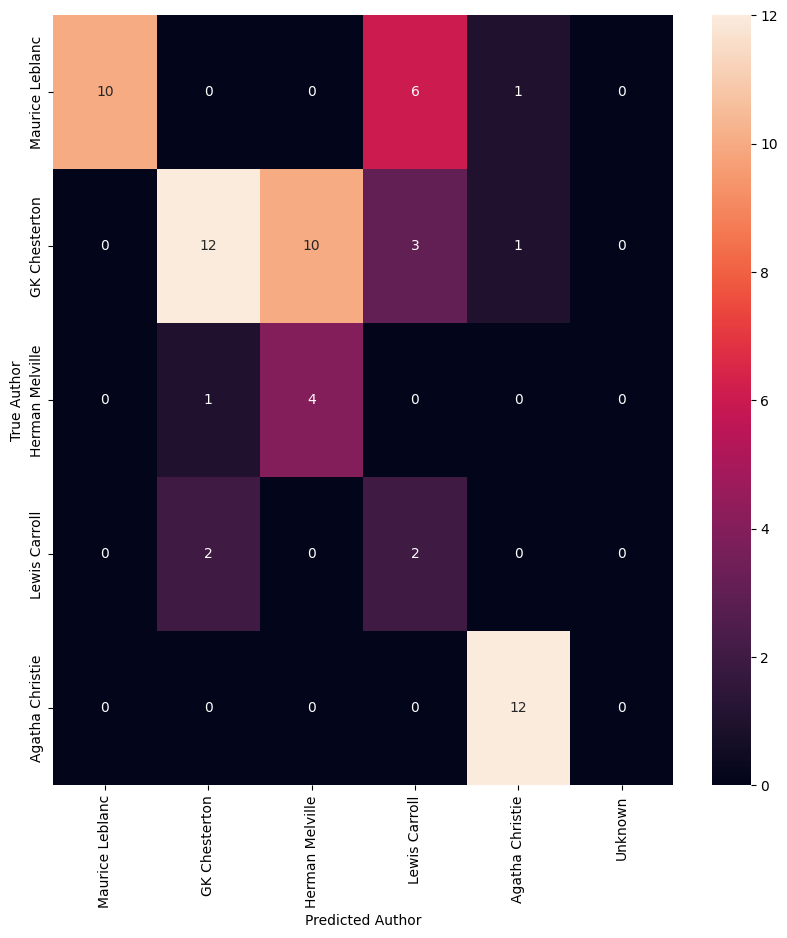

In [31]:
clustering_algorithm = KMeans(n_clusters=len(corpus.get_authors()))

most_common_clusters = {}
cluster_to_author = {}
while len(set(most_common_clusters.values())) < len(corpus.get_authors()):
    # Fit the model
    clustering_algorithm.fit(X_scaled)

    # Get the cluster assignments
    clusters = clustering_algorithm.predict(X_scaled)

    # Print the cluster assignments and true authors
    predicted_assignments = {work['title']: cluster for work, cluster in zip(corpus, clusters)}

    # Now assign the numbers to the authors
    author_assignments = {author: [] for author in corpus.get_authors()}
    for work in corpus:
        author_assignments[work['author']].append(predicted_assignments[work['title']])
        
    # Get the most common cluster for each author
    # Start with the most common cluster
    most_common_clusters = {}
    # Get number of works by each author
    author_counts = {author: len(works) for author, works in author_assignments.items()}
    authors_sorted_by_count = sorted(author_counts, key=lambda x: author_counts[x], reverse=True)
    
    # most_common_clusters = {author: max(set(assignments), key=assignments.count) for author, assignments in author_assignments.items()}
    most_common_clusters = {}
    for author, assignments in author_assignments.items():
        # Get the most common cluster for this author
        most_common_cluster = max(set(assignments), key=assignments.count)
        # If this cluster is already taken, find the next most common cluster
        while most_common_cluster in most_common_clusters.values():
            assignments.remove(most_common_cluster)
            if len(assignments) == 0:
                break
            most_common_cluster = max(set(assignments), key=assignments.count)
        most_common_clusters[author] = most_common_cluster
        
    cluster_to_author = {cluster: author for author, cluster in most_common_clusters.items()}

# Get the percent accuracy
correct = 0
confusion_matrix_unsupervised = np.zeros((len(corpus.get_authors()), len(corpus.get_authors()) + 1))
for work in corpus:
    true_author = work['author']
    try:
        predicted_author = cluster_to_author[predicted_assignments[work['title']]]
        if true_author == predicted_author:
            correct += 1
        confusion_matrix_unsupervised[authors.index(true_author), authors.index(predicted_author)] += 1
    except Exception as e:
        confusion_matrix_unsupervised[authors.index(true_author), -1] += 1
    
# SHow the confusion matrix
print(f'Accuracy: {correct / len(clusters) * 100:.2f}%')

# for work, cluster in zip(corpus, clusters):
#     print(f'{work["title"]} (by {work["author"]}): {cluster}')

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix_unsupervised, annot=True, fmt='g', xticklabels=list(most_common_clusters.keys()) + ['Unknown'], yticklabels=most_common_clusters.keys())
plt.xlabel('Predicted Author')
plt.ylabel('True Author')
plt.show()


In [32]:
class BinaryClassifier:
    def __init__(self, training_corpus: Corpus, author: str, chunk_size: int = 1):
        self.corpus = corpus
        self.author = author
        self.chunk_size = chunk_size
        self.model = None
        self.train()
        
    def train(self):
        # Get the works by the author
        works = self.corpus.chunk_sentences(self.chunk_size).get_works_by_author(self.author)
        # Get everyone else's works
        others = [work for work in self.corpus.chunk_sentences(self.chunk_size) if work['author'] != self.author]
        
        # Get the features for the works
        X = np.array([featurize(work) for work in works + others])
        # Get the labels for the works
        y = np.array([1] * len(works) + [0] * len(others))
        
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        
        # Train the model
        self.model = DecisionTreeRegressor()
        self.model.fit(X_train, y_train)
        
        
        # Show a confusion matrix
        y_pred = self.model.predict(X_test)
        y_pred = np.round(y_pred)
        confusion_matrix = np.zeros((2, 2))
        for true, pred in zip(y_test, y_pred):
            confusion_matrix[int(true), int(pred)] += 1
        
        print(confusion_matrix)
        # Graph the confusion matrix with seaborn
        plt.figure(figsize=(10, 10))
        sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=['Other', 'Agatha Christie'], yticklabels=['Other', 'Agatha Christie'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        # print(self.validate(self.corpus))
        
    def validate(self, corpus: Corpus) -> float:
        '''
        Validate the classifier on a corpus of works.
        This will return the percent accuracy of the classifier on the provided corpus,
        between 0 and 1.
        
        Parameters
        ----------
        corpus : Corpus
            The corpus of works to validate the classifier on. This will use the 'author'
            field of each work to determine the true label.
        
        Returns
        -------
        float
            The percent accuracy of the classifier on the provided corpus.
        '''
        # Show a confusion matrix
        confusion_matrix = np.zeros((2, 2))
        correct = 0
        for work in corpus:
            true = work['author'] == self.author
            pred = self.predict(work['text'], work['title'], work['author'])
            if true == pred:
                correct += 1
            confusion_matrix[int(true), int(pred)] += 1
            
        # Graph the confusion matrix with seaborn
        plt.figure(figsize=(10, 10))
        sns.heatmap(confusion_matrix, annot=True, fmt='g', xticklabels=['Other', 'Agatha Christie'], yticklabels=['Other', 'Agatha Christie'])
        plt.title('Provided Validation Set Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        return correct / len(corpus)
    
    def predict_chunk(self, chunk: str) -> bool:
        '''
        Make a prediction on a chunk of text.
        This will featurize the chunk, and return the predicted label.
        
        Parameters
        ----------
        chunk : str
            The chunk of text to make a prediction on.
            
        Returns
        -------
        bool
            The predicted label for the work. (True if the author is the same as the classifier's author)
        '''
        # Get the features for the text
        features = featurize({'title': 'Unknown', 'author': 'Unknown', 'text': chunk})
        X = np.array([features])
        
        # Predict the label
        return bool(self.model.predict(X)[0])
    
    def predict(self, text: str, title: str, author: str) -> bool:
        '''
        Make a prediction on a full work.
        This will chunk the text into smaller pieces, featurize each piece, and return the majority vote.
        
        Parameters
        ----------
        text : str
            The text of the work to make a prediction on.
        title : str
            The title of the work.
        author : str
            The author of the work.
            
        Returns
        -------
        bool
            The predicted label for the chunk. (True if the author is the same as the classifier's author)
        '''
        new_works = []
        sentences = tokens_to_sentences(tokenize(text))
        for i in range(0, len(sentences), self.chunk_size):
            chunk = ' '.join(sentences[i:i+self.chunk_size])
            new_works.append({'author': author, 'title': title, 'text': chunk})
                
        # Get the features for the text
        predictions = []
        confusion_matrix = np.zeros((2, 2))
        correct = 0
        incorrect = 0
        for i, work in enumerate(new_works):
            features = featurize(work)
            X = np.array([features])
            # Predict the label
            true = work['author'] == self.author
            pred = bool(self.model.predict(X)[0])
            predictions.append(pred)
            if true == pred:
                correct += 1
            else:
                incorrect += 1
            print(i, self.predict_chunk(work['text']), 'correct:', correct, 'incorrect:', incorrect)
            
            confusion_matrix[int(true), int(pred)] += 1
            
        print(sum(predictions), len(predictions))
        print(predictions)
        return sum(predictions) >= len(predictions) // 2
        

[[986.  53.]
 [ 52. 227.]]


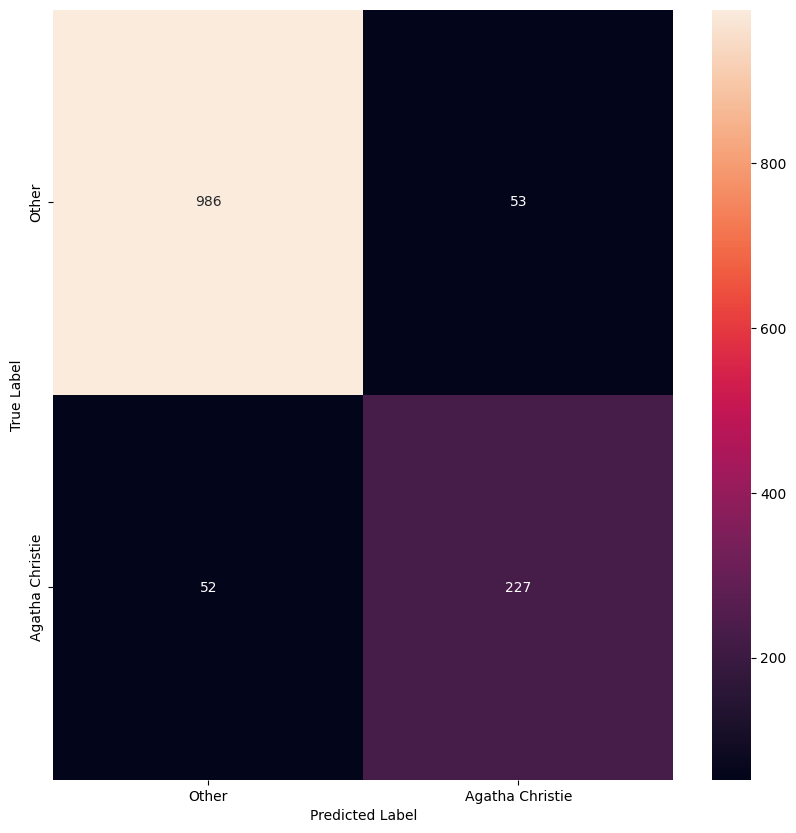

0 False correct: 0 incorrect: 1
1 True correct: 1 incorrect: 1
1 2
[False, True]
0 True correct: 1 incorrect: 0
1 1
[True]
0 False correct: 0 incorrect: 1
0 1
[False]
0 True correct: 1 incorrect: 0
1 1
[True]
0 False correct: 0 incorrect: 1
1 False correct: 0 incorrect: 2
0 2
[False, False]
0 True correct: 1 incorrect: 0
1 True correct: 2 incorrect: 0
2 2
[True, True]
0 True correct: 1 incorrect: 0
1 True correct: 2 incorrect: 0
2 2
[True, True]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
0 1
[False]
0 True correct: 1 incorrect: 0
1 1
[True]
0 False correct: 0 incorrect: 1
0 1
[False]
0 True correct: 1 incorrect: 0
1 1
[True]
0 False correct: 0 incorrect: 1
0 1
[False]
0 False correct: 0 incorrect: 1
1 False correct: 0 incorrect: 2
0 2
[False, False]


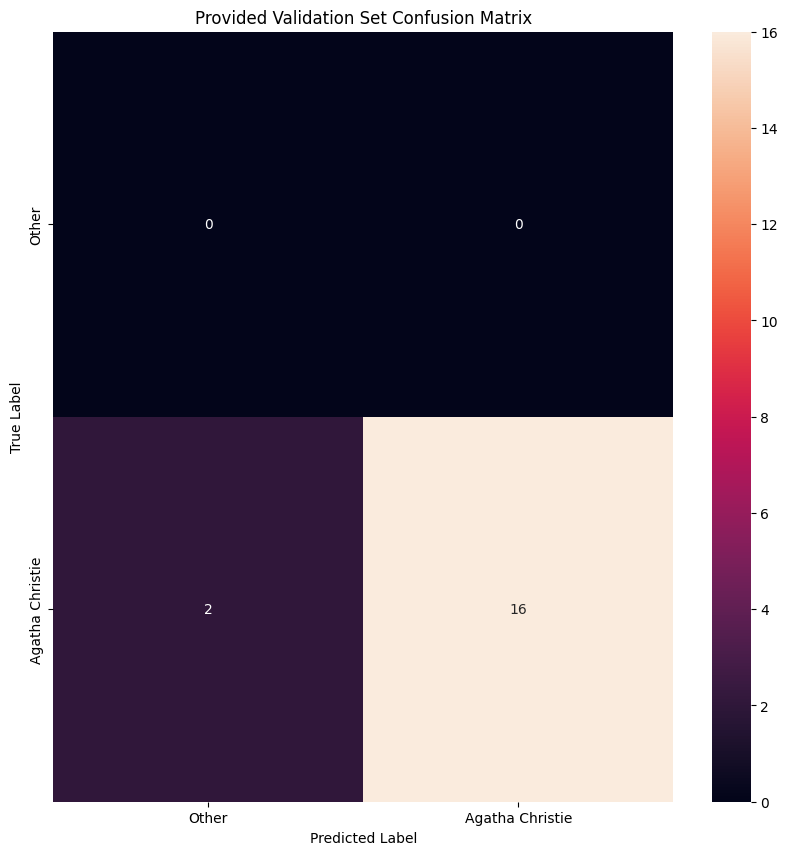

0.8888888888888888

In [33]:
# Predict the authors of the validation works
bc = BinaryClassifier(corpus, 'Agatha Christie', chunk_size=60)
bc.validate(validation_corpus)

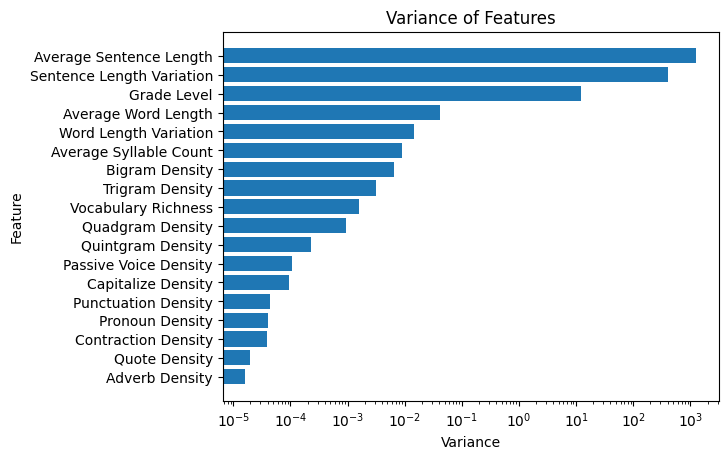

In [34]:
# Identify the variance in the features
# Get the variance of each feature
variances = np.var(X_scaled, axis=0)
# Get the indices of the features sorted by variance
sorted_indices = np.argsort(variances)

feature_names = sorted(featurize_with_names(corpus[0]).keys())

# Plot the variances of the features
plt.barh(range(len(variances)), variances[sorted_indices])
plt.yticks(range(len(variances)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.title('Variance of Features')
# Log scale
plt.xscale('log')
plt.show()

In [35]:
# Plot the clusters as a 3d graph over the three most varying features
from mpl_toolkits.mplot3d import Axes3D

# Get the three most varying features
most_varying = sorted_indices[-3:]

df = pd.DataFrame()
for work in corpus:
    features = featurize_with_names(work)
    df = pd.concat([df, pd.DataFrame([work | features])])

# Get the features for the three most varying features
X_3d = df[feature_names].values
# Scale the data
X_3d_scaled = X_3d


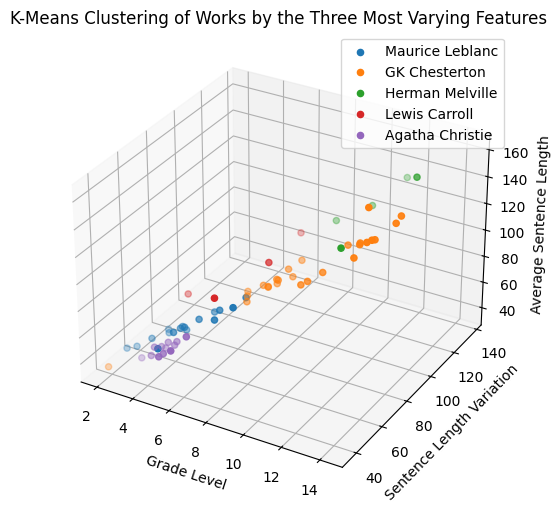

In [36]:
# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three most varying features, colored by author
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[most_varying[0]]], author_data[feature_names[most_varying[1]]], author_data[feature_names[most_varying[2]]], label=author)
    
ax.set_xlabel(feature_names[most_varying[0]])
ax.set_ylabel(feature_names[most_varying[1]])
ax.set_zlabel(feature_names[most_varying[2]])
plt.title('K-Means Clustering of Works by the Three Most Varying Features')
plt.legend()
plt.show()

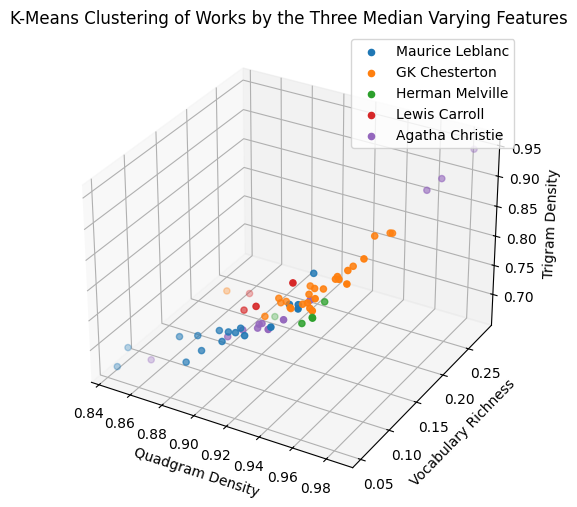

In [37]:

# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three median varying features, colored by author
median_varying = sorted_indices[len(sorted_indices) // 2 - 1:len(sorted_indices) // 2 + 2]
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[median_varying[0]]], author_data[feature_names[median_varying[1]]], author_data[feature_names[median_varying[2]]], label=author)
    
ax.set_xlabel(feature_names[median_varying[0]])
ax.set_ylabel(feature_names[median_varying[1]])
ax.set_zlabel(feature_names[median_varying[2]])

plt.title('K-Means Clustering of Works by the Three Median Varying Features')
plt.legend()
plt.show()


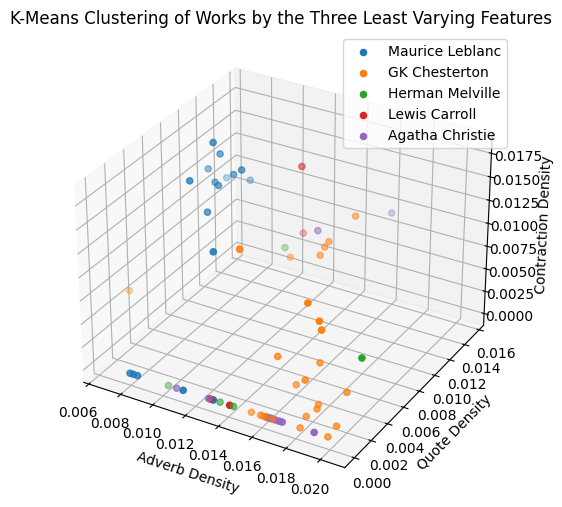

In [38]:

# Plot the clusters
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(111, projection='3d')

# Show the clusters by the three least varying features, colored by author
for author in corpus.get_authors():
    author_data = df[df['author'] == author]
    ax.scatter(author_data[feature_names[sorted_indices[0]]], author_data[feature_names[sorted_indices[1]]], author_data[feature_names[sorted_indices[2]]], label=author)
    
ax.set_xlabel(feature_names[sorted_indices[0]])
ax.set_ylabel(feature_names[sorted_indices[1]])
ax.set_zlabel(feature_names[sorted_indices[2]])
plt.title('K-Means Clustering of Works by the Three Least Varying Features')
plt.legend()
plt.show()
